In [1]:
# Import packages 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import ast
from scipy.stats import linregress

# Sensor dose-response curves

### Read in CSVs

In [2]:
# GFP fold-change 
MG_hm9_DR_df = pd.read_csv('MG_hm9_DR.csv',index_col=0)

# Sensors and their cognate heavy metal 
metal_sensor = pd.read_csv('sensors.csv')
metal_sensor = metal_sensor.sort_values(by='sensor')

### Graph dose-responses 

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_46831/4022947668.py:5: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_46831/4022947668.py:5: RuntimeWarning: invalid value encountered in power
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_46831/4022947668.py:5: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_46831/4022947668.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=9, fontfamily='Helvetica')
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_46831/4022947668.py:5: RuntimeWarning: divide by zero encountered in divide
  return b + (a-b)/(1 + (EC50/X)**h)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_46831/4022947668.py:5:

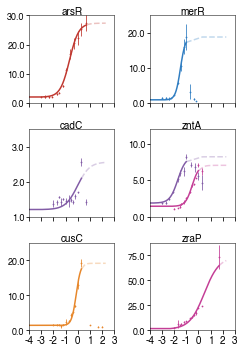

In [3]:
# ----------------------------------

# Hill equation
def func(X, EC50, h):
    return b + (a-b)/(1 + (EC50/X)**h)

# ----------------------------------


# Initialize output dataframe
fit_MG_hm9 = pd.DataFrame(columns=[
    'hm', 'sensor', 'a', 'b',
    'EC50', 'EC50_std',
    'h', 'h_std',
    'strain', 'cond'
])

# Color mapping for heavy metals
colors = {
    'Cu': '#E7872B',
    'As': '#C03830',
    'Hg': '#317EC2',
    'Cd': '#825CA6',
    'Pb': '#C43E96'
}

# Create subplot grid
fig, axes = plt.subplots(
    3, 2,
    figsize=(3.5, 5),
    facecolor='white',
    sharex=True
)

# Thin axis spines
for ax in axes.flat:
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

# Loop over each metal–sensor pair
for i in range(len(metal_sensor)):

    curr = metal_sensor.iloc[i]

    # Extract and prepare data
    data = MG_hm9_DR_df.loc[
        (MG_hm9_DR_df['hm'] == curr.hm) &
        (MG_hm9_DR_df['sensor'] == curr.sensor)
    ].copy()

    data['ppm'] = data['ppm'].astype(float)
    data = data.sort_values(by='ppm')

    conc = data['ppm'].unique()

    # Compute mean and std at each concentration
    means, stds = [], []
    for ppm in conc:
        means.append(data[data.ppm == ppm]['max'].mean())
        stds.append(data[data.ppm == ppm]['max'].std())

    # Baseline parameters
    a = np.max(means)
    b = means[0]

    # Hill curve fitting (with exclusions as described in text)
    popt, pcov = curve_fit(func, conc, means)

    if curr.sensor == 'merR':
        popt, pcov = curve_fit(func, conc[:9], means[:9])

    elif curr.sensor in ['cadC', 'cusC']:
        popt, pcov = curve_fit(func, conc[:13], means[:13])

    elif curr.sensor == 'zntA' and curr.hm == 'Cd':
        popt, pcov = curve_fit(func, conc[:8], means[:8])

    elif curr.sensor == 'zntA' and curr.hm == 'Pb':
        stds = stds[:13]
        popt, pcov = curve_fit(func, conc[:12], means[:12])

    else:
        popt, pcov = curve_fit(func, conc[1:], means[1:])

    # Extract parameters
    EC50, h = popt
    EC50_std, h_std = np.sqrt(np.diag(pcov))

    # Store fit results
    fit_MG_hm9.loc[len(fit_MG_hm9)] = [
        curr.hm, curr.sensor, a, b,
        EC50, EC50_std, h, h_std,
        'MG', 'HM9'
    ]

    # Select subplot axis (manual layout)
    if i < 3:
        ax = axes[i, 0]
    elif i == 6:
        ax = axes[2, 1]
    else:
        ax = axes[i - 3, 1]

    # Determine fit endpoint (as described in text)
    endpt = conc[-1]

    if curr.sensor in ['merR', 'cusC']:
        endpt = conc[-4]

    elif curr.sensor == 'cadC':
        endpt = conc[-2]

    elif curr.sensor == 'zntA' and curr.hm == 'Cd':
        endpt = conc[-5]

    elif curr.sensor == 'zntA' and curr.hm == 'Pb':
        endpt = conc[-2]
        ax = axes[i - 4, 1]

    # Plot Hill fit 
    x_fit = np.linspace(0, endpt, 10000)
    x_ext = np.linspace(endpt, 200, 100)

    ax.plot(x_fit, func(x_fit, *popt), color=colors[curr.hm])
    ax.plot(x_ext, func(x_ext, *popt),
            '--', alpha=0.3, color=colors[curr.hm])

    ax.errorbar(
        conc, means, yerr=stds,
        fmt='.', color=colors[curr.hm],
        markersize=1.5, elinewidth=0.8,
        mew=1, capsize=0
    )

    # Axis formatting
    ax.set_xscale('log')
    ax.set_xlim(1e-4, 1e2)

    xticks = [10**i for i in range(-4, 4)]
    xlabels = ['-4', '-3', '-2', '-1', '0', '1', '2', '3']

    ax.set_xticks(xticks)
    ax.set_title(curr.sensor, fontsize=10, pad=1, fontfamily='Helvetica')

    # y-axis limits (to display graphs clearly)
    if curr.hm == 'Cu':
        ax.set_ylim(0, 25)
    elif curr.hm == 'As':
        ax.set_ylim(0, 30)
    elif curr.hm == 'Hg':
        ax.set_ylim(0, 25)
    elif curr.hm == 'Cd' and curr.sensor == 'cadC':
        ax.set_ylim(1, 3.5)
    elif curr.hm == 'Pb' and curr.sensor == 'zraP':
        ax.set_ylim(0, 70)
    elif curr.hm == 'Pb' and curr.sensor == 'zntA':
        ax.set_ylim(0, 12)

    # Show x tick labels only on bottom row
    if i == len(metal_sensor) - 1 or i == 2:
        ax.set_xticklabels(xlabels, fontsize=10, fontfamily='Helvetica')

    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_yticklabels(ax.get_yticks(), fontsize=9, fontfamily='Helvetica')

# Final layout
plt.tight_layout()